# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy import optimize
from astropy.io import fits
import astropy.coordinates as coord
import pandas as pd
import os
from tabulate import tabulate
from jwst.residual_fringe.utils import fit_residual_fringes_1d as rf1d
import healpy as hp

# Parameters

In [2]:
t1 = 5  #truncation wvl 1
t2 = 27.8  #truncation wvl 2
arcsec_to_usr = 1e-4/4.25
fov1 =  3.2*3.7*arcsec_to_usr  #u*sr
fov2 =  4.0*4.8*arcsec_to_usr  #u*sr
fov3 =  5.2*6.2*arcsec_to_usr  #u*sr
fov4 =  6.6*7.7*arcsec_to_usr  #u*sr

# Functions

### General

In [3]:
def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while (arr[i]<x):
        i += 1
    return i

def truncation(wvl, flux, error, wvlT1=np.inf, wvlT2=np.inf):
    if (wvlT1==np.inf):
        p1 = 0
    else:
        p1 = locate(wvl,wvlT1)
    if (wvlT2==np.inf):
        p2 = len(wvl)
    else:
        p2 = locate(wvl,wvlT2)
    wvl_t = wvl[p1:p2]
    flux_t = flux[p1:p2]
    error_t = error[p1:p2]
    return wvl_t, flux_t, error_t


def defringe(wvl, flux, error, CH, M1=np.inf, M2=np.inf):
    flux_c = rf1d(flux,wvl,channel=CH)
    if not (M1==np.inf):
        p1 = locate(wvl,M1) 
        p2 = locate(wvl,M2)
        wvlCut = wvl[p1:p2]
        fluxCut_c = flux_c[p1:p2]
        fluxCut = flux[p1:p2]
        errorCut = error[p1:p2]   
        plt.figure(figsize=(9,6))
        plt.plot(wvlCut,fluxCut_c,label='rf1d')
        plt.fill_between(wvlCut,fluxCut_c+errorCut,fluxCut_c-errorCut,step="pre",color='silver')
        plt.plot(wvlCut,fluxCut,'--',label='raw')
        plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
        plt.legend()
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.show()
    return flux_c

def linReg(xarr,yarr):
    f = lambda p,x : p[0]*x+p[1]
    lsq = lambda p : np.sum((yarr - f(p,xarr))**2)
    minitial = (yarr[-1]-yarr[0])/(xarr[-1]-xarr[0])
    pinitial = np.array([minitial,yarr[0]-minitial*xarr[0]])
    minlsq = optimize.minimize(lsq,pinitial)
    return minlsq.x, minlsq.fun

def plotallch(data_ch1,data_ch2,data_ch3,data_ch4,M1,M2,LABEL='Unknown'):
    wvl_ch1, flux_ch1, err_ch1 = data_ch1
    wvl_ch2, flux_ch2, err_ch2 = data_ch2
    wvl_ch3, flux_ch3, err_ch3 = data_ch3
    wvl_ch4, flux_ch4, err_ch4 = data_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    plt.plot(wvlCut,fluxCut,'--',label=LABEL)
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')

def dupl_rbespal(c):
    alreadyAdded = False
    dupl_c = dict()
    sorted_ind_c = sorted(range(len(c)), key=lambda x: c[x]) # sort incoming list but save the indexes of sorted items

    for i in xrange(len(c) - 1): # loop over indexes of sorted items
        if c[sorted_ind_c[i]] == c[sorted_ind_c[i+1]]: # if two consecutive indexes point to the same value, add it to the duplicates
            if not alreadyAdded:
                dupl_c[c[sorted_ind_c[i]]] = [sorted_ind_c[i], sorted_ind_c[i+1]]
                alreadyAdded = True
            else:
                dupl_c[c[sorted_ind_c[i]]].append( sorted_ind_c[i+1] )
        else:
            alreadyAdded = False
    return dupl_c
    
def checkASN(asn,asnArr):  #0: ASN does not exist, #1: ASN exists
    for i in range(len(asnArr)):
        if (asn==asnArr[i]):
            return 1
    return 0

### Read fits

In [214]:
class readFits:

    def __init__(self, DirName, plotSpec=True, defringe=True, sysErr=np.inf, M1=np.inf, M2=np.inf):

        ######################################
        wvlName = 'WAVELENGTH'
        fluxName = 'FLUX'
        errorName = 'FLUX_ERROR'
        SBName = 'SURF_BRIGHT'
        exptName = 'EFFEXPTM'
        raName = 'SLIT_RA'
        decName = 'SLIT_DEC'

        ######################################
        self.dropSpec = 0
        self.M1 = M1
        self.M2 = M2
        self.sysErr = sysErr
        self.hdul_ch1, self.hdul_ch2, self.hdul_ch3, self.hdul_ch4 = self.getDiffCh(DirName)
        self.exptime = np.array([self.hdul_ch1[0].header[exptName],self.hdul_ch2[0].header[exptName],self.hdul_ch3[0].header[exptName],self.hdul_ch4[0].header[exptName]])
        self.ra = self.hdul_ch1[1].header[raName]  #deg
        self.dec = self.hdul_ch1[1].header[decName]  #deg
        self.spcfct = self.getSpec(self.hdul_ch1)
        self.srctype = self.spcfct[2]
        self.bkgtarg = self.spcfct[3]
        self.ASN = self.hdul_ch1[0].header['ASNPOOL']
        self.wvl_ch1 = self.hdul_ch1[1].data[wvlName]
        self.flux_ch1 = self.hdul_ch1[1].data[fluxName]*1e-6
        self.err_ch1 = self.hdul_ch1[1].data[errorName]*1e-6
        self.SB_ch1 = self.hdul_ch1[1].data[SBName]
        self.wvl_ch2 = self.hdul_ch2[1].data[wvlName]
        self.flux_ch2 = self.hdul_ch2[1].data[fluxName]*1e-6
        self.err_ch2 = self.hdul_ch2[1].data[errorName]*1e-6
        self.SB_ch2 = self.hdul_ch2[1].data[SBName]
        self.wvl_ch3 = self.hdul_ch3[1].data[wvlName]
        self.flux_ch3 = self.hdul_ch3[1].data[fluxName]*1e-6
        self.err_ch3 = self.hdul_ch3[1].data[errorName]*1e-6
        self.SB_ch3 = self.hdul_ch3[1].data[SBName]
        self.wvl_ch4 = self.hdul_ch4[1].data[wvlName]
        self.flux_ch4 = self.hdul_ch4[1].data[fluxName]*1e-6
        self.err_ch4 = self.hdul_ch4[1].data[errorName]*1e-6
        self.SB_ch4 = self.hdul_ch4[1].data[SBName]

        ######################################
        if (np.sum(self.flux_ch1)==0) or (np.sum(self.flux_ch2)==0) or (np.sum(self.flux_ch3)==0) or (np.sum(self.flux_ch4)==0):
            self.dropSpec = 1
            #print("This is a null data set")
        if (self.wvl_ch1[0]>t1) or (self.wvl_ch4[-1]<t2):
            self.dropSpec = 1
            #print("This data set does not have the suitable range")
        if (self.srctype =='POINT'):
            self.dropSpec = 1
            #print("This is a point source")
        if (self.bkgtarg == True):
            self.dropSpec = 1
            #print("This is an intended background observation")
        if (self.dropSpec==0):
            self.data_ch1 = self.speccorr(self.wvl_ch1,self.flux_ch1,self.err_ch1,self.SB_ch1,1,p1=t1)
            self.data_ch2 = self.speccorr(self.wvl_ch2,self.flux_ch2,self.err_ch2,self.SB_ch1,2)
            self.data_ch3 = self.speccorr(self.wvl_ch3,self.flux_ch3,self.err_ch3,self.SB_ch1,3)
            self.data_ch4 = self.speccorr(self.wvl_ch4,self.flux_ch4,self.err_ch4,self.SB_ch1,4,p2=t2)
            if (plotSpec==True):
                self.previewSpec()
    
    def getDiffCh(self,Dir):
        visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
        for fitsFile in visFile:
            if 'ch1' in fitsFile:
                hdul_ch1 = fits.open(Dir+'/'+fitsFile)
            elif 'ch2' in fitsFile:
                hdul_ch2 = fits.open(Dir+'/'+fitsFile)
            elif 'ch3' in fitsFile:
                hdul_ch3 = fits.open(Dir+'/'+fitsFile)
            elif 'ch4' in fitsFile:
                hdul_ch4 = fits.open(Dir+'/'+fitsFile)
        return hdul_ch1, hdul_ch2, hdul_ch3, hdul_ch4
    
    def speccorr(self,wvl,flux,err,surfB,ch,p1=np.inf,p2=np.inf):
        wvl_p, flux_p, err_p = truncation(wvl, flux, err, wvlT1=p1, wvlT2=p2)
        wvl_p, surfB_p, err_p = truncation(wvl, surfB, err, wvlT1=p1, wvlT2=p2)
        
        #Assuming the solid angle is constant throughout 1 obs and 1 ch
        binNo = len(flux_p)
        count=0
        solidAn_avg = 0
        for i in range(binNo):
            if (surfB_p[i]!=0):
                solidAn_avg += flux_p[i]/surfB_p[i]
                count += 1
        if (count==0):
            print(surfB_p)
        solidAn = solidAn_avg/count*np.ones(binNo)

        ######################################
        if (defringe==True):
            flux_p = rf1d(flux_p,wvl,channel=ch)
        if not (self.sysErr==np.inf):
            err_p += flux_p*self.sysErr
        data = np.array([wvl_p,flux_p,err_p,solidAn,surfB_p])  
        return data

    def getSpec(self,datafile):
        df0 = datafile[0]
        title = df0.header['TITLE']
        targName = df0.header['TARGNAME']
        srctyp = df0.header['SRCTYAPT']
        bkgtarg = df0.header['BKGDTARG']
        effexp = df0.header['EFFEXPTM']
        asn = df0.header['ASNPOOL']
        dataprob = df0.header['DATAPROB']
        return [title,targName,srctyp,bkgtarg,effexp,asn,dataprob]
        
    def previewSpec(self):
        #Basic info:
        print("Channel 1:")
        print("Wavelength range:", (self.wvl_ch1[0],self.wvl_ch1[-1]))
        print("Array shape:", self.wvl_ch1.shape)
        print("Bin size (dlmd):", self.wvl_ch1[1]-self.wvl_ch1[0])
        print("Channel 2:")
        print("Wavelength range:", (self.wvl_ch2[0],self.wvl_ch2[-1]))
        print("Array shape:", self.wvl_ch2.shape)
        print("Bin size (dlmd):", self.wvl_ch2[1]-self.wvl_ch2[0])
        print("Channel 3:")
        print("Wavelength range:", (self.wvl_ch3[0],self.wvl_ch3[-1]))
        print("Array shape:", self.wvl_ch3.shape)
        print("Bin size (dlmd):", self.wvl_ch3[1]-self.wvl_ch3[0])
        print("Channel 4:")
        print("Wavelength range:", (self.wvl_ch4[0],self.wvl_ch4[-1]))
        print("Array shape:", self.wvl_ch4.shape)
        print("Bin size (dlmd):", self.wvl_ch4[1]-self.wvl_ch4[0])
        bkgdName = 'BACKGROUND'
        bkgd_ch1 = self.hdul_ch1[1].data[bkgdName]
        bkgd_ch2 = self.hdul_ch2[1].data[bkgdName]
        bkgd_ch3 = self.hdul_ch3[1].data[bkgdName]
        bkgd_ch4 = self.hdul_ch4[1].data[bkgdName]
    
        plt.figure(figsize=(9,9))
        plt.subplot(411)
        plt.step(self.data_ch1[0],self.data_ch1[1])
        plt.step(self.data_ch2[0],self.data_ch2[1])
        plt.step(self.data_ch3[0],self.data_ch3[1])
        plt.step(self.data_ch4[0],self.data_ch4[1])
        #plt.yscale('log')
        plt.ylim(0,8000)
        plt.title('Total flux (processed)')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(412)
        plt.step(self.wvl_ch1,self.flux_ch1)
        plt.step(self.wvl_ch2,self.flux_ch2)
        plt.step(self.wvl_ch3,self.flux_ch3)
        plt.step(self.wvl_ch4,self.flux_ch4)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(413)
        plt.step(self.wvl_ch1,self.SB_ch1)
        plt.step(self.wvl_ch2,self.SB_ch2)
        plt.step(self.wvl_ch3,self.SB_ch3)
        plt.step(self.wvl_ch4,self.SB_ch4)
        plt.ylim(0,8000)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'SURF_BRIGHT\' against \'WAVELENGTH\'') #plt.title('Subject')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(414)
        plt.step(self.wvl_ch1,bkgd_ch1)
        plt.step(self.wvl_ch2,bkgd_ch2)
        plt.step(self.wvl_ch3,bkgd_ch3)
        plt.step(self.wvl_ch4,bkgd_ch4)
        plt.ylim(0,8000)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'BACKGROUND\' against \'WAVELENGTH\'') #plt.title('Background')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.tight_layout(pad=0.9)
        #plt.savefig('exampleSpectrum_2')
        if not (self.M1==np.inf):
            data_ch1_r = np.array([self.wvl_ch1,self.flux_ch1,self.err_ch1])
            data_ch2_r = np.array([self.wvl_ch2,self.flux_ch2,self.err_ch2])
            data_ch3_r = np.array([self.wvl_ch3,self.flux_ch3,self.err_ch3])
            data_ch4_r = np.array([self.wvl_ch4,self.flux_ch4,self.err_ch4])
            plt.figure(figsize=(9,6))
            plotallch(self.data_ch1, self.data_ch2, self.data_ch3, self.data_ch4, self.M1, self.M2, 'processed')
            plotallch(data_ch1_r, data_ch2_r, data_ch3_r, data_ch4_r, self.M1, self.M2, 'raw')
            plt.legend()
            plt.xlabel("Wavelength ($\\mu$m)")
            plt.ylabel("$\\Phi$ (MJy/sr)")
            
def readFitsDir(Dir,printTable=True,skymap=True,defr=True,sysError=np.inf):  #Read a directory containing multiple .fits
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    fileNo = len(visFile)
    for i in range(fileNo):
        rf = readFits(Dir+'/'+visFile[i],plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.dropSpec==0):
            binNo1 = np.ma.size(rf.data_ch1,axis=1)
            binNo2 = np.ma.size(rf.data_ch2,axis=1)
            binNo3 = np.ma.size(rf.data_ch3,axis=1)
            binNo4 = np.ma.size(rf.data_ch4,axis=1)
            break
    Ch1Arr = np.zeros((fileNo,5,binNo1))
    Ch2Arr = np.zeros((fileNo,5,binNo2))
    Ch3Arr = np.zeros((fileNo,5,binNo3))
    Ch4Arr = np.zeros((fileNo,5,binNo4))
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    ASNPOOL = np.array([])
    badData = np.zeros(fileNo)  #0: bad, 1: good
    fspec = open("dataSpec.txt", "w")
    fspec.write("Title \t TargetName \t SourceType \t BkgTarget \t EffExp [s] \t RA \t DEC \t ASN \t DataProblem \n")
    #spcfct = np.array([['title','targName','srctyp','bkgtarg','effexp','asn','dataprob'],])

    for i in range(fileNo):
        fileName = visFile[i]
        rf = readFits(Dir+'/'+fileName,plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.dropSpec==0):
            Ch1Arr[i,:,:] = rf.data_ch1
            Ch2Arr[i,:,:] = rf.data_ch2 
            Ch3Arr[i,:,:] = rf.data_ch3
            Ch4Arr[i,:,:] = rf.data_ch4
            exptArr[i,:] = rf.exptime
            longArr[i] = rf.ra
            latArr[i] = rf.dec
            fspec.write(rf.spcfct[0]+'\t'+rf.spcfct[1]+'\t'+rf.spcfct[2]+'\t'+str(rf.spcfct[3])+'\t'+str(rf.spcfct[4])+'\t'+str(rf.ra)+'\t'+str(rf.dec)+'\t'+rf.spcfct[5]+'\t'+str(rf.spcfct[6])+'\n')
            #spcfct = np.append(spcfct,[rf.spcfct],axis=0)
            #if (checkASN(rf.ASN,ASNPOOL)==0):
            ASNPOOL = np.append(ASNPOOL,rf.ASN)
            badData[i] = 1
        # else:
        #     print("This is file", i)
    fspec.close()
    zeroArg = np.argwhere(badData==0)
    Ch1Arr = np.delete(Ch1Arr, zeroArg, axis=0)
    Ch2Arr = np.delete(Ch2Arr, zeroArg, axis=0)
    Ch3Arr = np.delete(Ch3Arr, zeroArg, axis=0)
    Ch4Arr = np.delete(Ch4Arr, zeroArg, axis=0)
    exptArr = np.delete(exptArr, zeroArg, axis=0)
    longArr = np.delete(longArr, zeroArg, axis=0)
    latArr = np.delete(latArr, zeroArg, axis=0)
    newFileNo = len(longArr)
    sc = coord.SkyCoord(ra=longArr, dec=latArr, unit="deg").galactic
    longArr = sc.l.rad
    latArr = sc.b.rad

    #########################################################################
    if (printTable==True):
        myTable = np.transpose(np.array([np.mean(exptArr,axis=1),longArr,latArr]))
        head = np.array(['Exptime (s)','Longtitude (rad)','Latitude (rad)'])
        print(tabulate(myTable,headers=head))
    print('No. of file:', fileNo)
    print('No. of used file:', newFileNo)
    print('Total exptime:', np.sum(np.mean(exptArr,axis=1)), '(s)')
    if (skymap==True):
        NSIDE = 256
        N = 20
        m = np.zeros(hp.nside2npix(NSIDE))
        for i in range(newFileNo):
            vec = hp.ang2vec(longArr[i]*180/np.pi,latArr[i]*180/np.pi,lonlat=True)
            ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(2))
            m[ipix_disc] = np.mean(exptArr[i,:])
        hp.mollview(m, title="Sampled data",unit='Exp time (s)', cmap='cividis')
        hp.graticule(dpar=15)
        plt.show()
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr

### Stacking

In [211]:
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=True,interp=False,setWvl=0):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    flux_ch1 = np.zeros(binNo1)
    flux_ch2 = np.zeros(binNo2)
    flux_ch3 = np.zeros(binNo3)
    flux_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    exptime = np.zeros(fileNo)
    total_sr1 = np.sum(Ch1Arr[:,3,:],axis=0)
    total_sr2 = np.sum(Ch2Arr[:,3,:],axis=0)
    total_sr3 = np.sum(Ch3Arr[:,3,:],axis=0)
    total_sr4 = np.sum(Ch4Arr[:,3,:],axis=0)
    SNR = np.zeros(fileNo)
    
    for i in range(fileNo):
        exptTotal = np.sum(exptArr[0:i+1,:],axis=0)
        exptime[i] = np.mean(exptTotal)
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
            Ch1Arr[i,2,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,2,:])
            Ch2Arr[i,2,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,2,:])
            Ch3Arr[i,2,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,2,:])
            Ch4Arr[i,2,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,2,:])
        flux_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        flux_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        flux_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        flux_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,1]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,1]
        NSR = abs(np.concatenate((np.sqrt(dn_total_ch1)/flux_ch1,np.sqrt(dn_total_ch2)/flux_ch2,np.sqrt(dn_total_ch3)/flux_ch3,np.sqrt(dn_total_ch4)/flux_ch4)))
        SNR[i] = 1/np.mean(NSR)
    wvl_ch1 = Ch1Arr[setWvl,0,:]
    wvl_ch2 = Ch2Arr[setWvl,0,:]
    wvl_ch3 = Ch3Arr[setWvl,0,:]
    wvl_ch4 = Ch4Arr[setWvl,0,:]
    flux_ch1 = flux_ch1/exptTotal[0]/total_sr1
    flux_ch2 = flux_ch2/exptTotal[1]/total_sr2
    flux_ch3 = flux_ch3/exptTotal[2]/total_sr3
    flux_ch4 = flux_ch4/exptTotal[3]/total_sr4
    err_ch1 = np.sqrt(dn_total_ch1)/exptTotal[0]/total_sr1
    err_ch2 = np.sqrt(dn_total_ch2)/exptTotal[1]/total_sr2
    err_ch3 = np.sqrt(dn_total_ch3)/exptTotal[2]/total_sr3
    err_ch4 = np.sqrt(dn_total_ch4)/exptTotal[3]/total_sr4
    if (defr==True):
        flux_ch1 = defringe(wvl_ch1,flux_ch1,err_ch1,CH=1)
        flux_ch2 = defringe(wvl_ch2,flux_ch2,err_ch2,CH=2,M1=8.25,M2=8.75)
        flux_ch3 = defringe(wvl_ch3,flux_ch3,err_ch3,CH=3)
        flux_ch4 = defringe(wvl_ch4,flux_ch4,err_ch4,CH=4)
    stkdata_ch1 = np.array([wvl_ch1,flux_ch1,err_ch1])
    stkdata_ch2 = np.array([wvl_ch2,flux_ch2,err_ch2])
    stkdata_ch3 = np.array([wvl_ch3,flux_ch3,err_ch3])
    stkdata_ch4 = np.array([wvl_ch4,flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, plotStyl='log', M1=5.350, M2=5.525, Ch1Arr=[],Ch2Arr=[],Ch3Arr=[],Ch4Arr=[]):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))  
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]

    #########################################################################
    plt.figure(figsize=(9,6))
    if not(len(Ch1Arr)==0):
            fileNo = np.ma.size(Ch1Arr,axis=0)
            data_unstk = np.concatenate((Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr),axis=2)
            for  i in range(fileNo):
                wvlCut_unstk, fluxCut_unstk, errorCut_unstk,_,sbCut_unstk = data_unstk[i,:,p1:p2]
                plt.subplot(211) 
                plt.step(data_unstk[i,0,:],data_unstk[i,4,:],linestyle='dotted',linewidth=0.3)
                plt.subplot(212)
                plt.step(wvlCut_unstk,sbCut_unstk,linestyle='dotted',linewidth=0.5)
                #plt.fill_between(wvlCut_unstk,sbCut_unstk+errorCut_unstk,sbCut_unstk-errorCut_unstk,step="pre",color='silver')
    plt.subplot(211)  
    #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
    plt.step(wvl,flux,'black',label='Stacked',linewidth=2.5)
    plt.fill_between(wvl,flux+err,flux-err,step="pre",color='silver',linewidth=2.5)
    #plt.axhline(y=0,linestyle='--')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    # plt.xscale('log')
    plt.yscale(plotStyl)
    #plt.ylim(0, 0.3)
    plt.legend()
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black',label='Stacked')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver',linewidth=2.5)
    #plt.ylim(0.08,0.14)
    plt.yscale(plotStyl)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    plt.tight_layout(pad=0.9)
    plt.legend()

# Read fits

This is file 0
This is file 2
This is file 4
This is file 5
This is file 6
This is file 8
This is file 10
This is file 11
This is file 13
This is file 15
This is file 17
This is file 19
This is file 22
This is file 23
This is file 24
This is file 26
This is file 27
This is file 28
This is file 30
This is file 32
This is file 34
This is file 36
This is file 45
This is file 46
This is file 47
This is file 48
This is file 49
This is file 52
This is file 53
This is file 54
This is file 57
This is file 63
This is file 65
This is file 70
This is file 71
This is file 73
This is file 77
This is file 78
This is file 79
This is file 82
This is file 83
This is file 84
This is file 85
This is file 86
This is file 88
This is file 90
This is file 92
This is file 93
This is file 94
This is file 95
This is file 96
This is file 97
This is file 98
This is file 100
This is file 102
This is file 104
This is file 105
This is file 106
This is file 107
This is file 108
This is file 110
This is file 111
This 

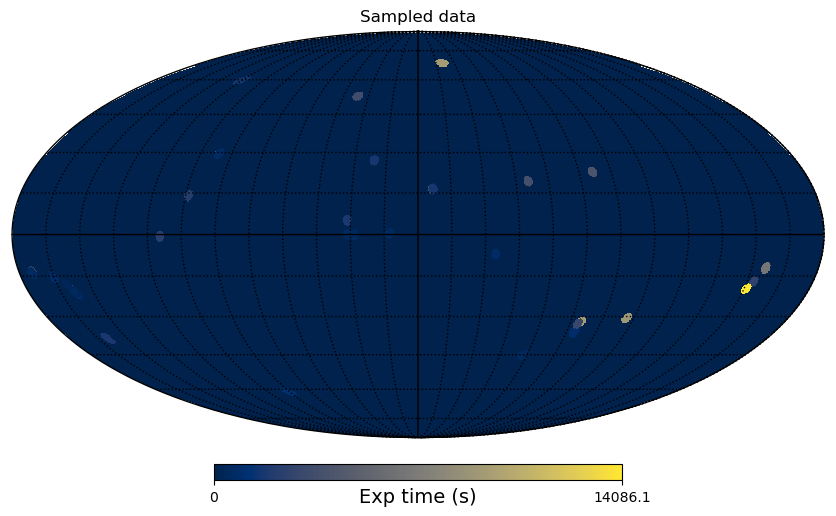

In [212]:
#Read data:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr = readFitsDir("../raw_data/MRS_156",skymap=True,defr=False,sysError=0.1)

## Samples

In [164]:
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data
folderName = 'jw01024-c1000_t002_miri'
#fitsFile = "../raw_data/MRS_all_data/"+folderName+"/x1d_ch1.fits"
fitsFile = "../raw_data/MRS_20/"+folderName+"/"+folderName+"_ch4-shortmediumlong_x1d.fits"
sub = fits.open(fitsFile)
print(sub.info())
print('###############################################################################')
print(sub[1].header['SRCTYPE'])
print(sub[0].header['SRCTYAPT'])
print(sub[0].header['BKGDTARG'])
#print(sub[0].header['BKGSUB'])
print(sub[0].header['S_MRSMAT'])
#print(sub[0].header['S_BKDSUB'])
#print(sub[0].header['S_MSBSUB'])
print(sub[0].header['EFFEXPTM'])
print(sub[0].header['ASNPOOL'])
print('###############################################################################')
print(sub[0].header)
# # from stdatamodels.jwst.datamodels import ImageModel
# # model = ImageModel(fitsFile)
# # model.data
# import stdatamodels.asdf_in_fits as asdfInFits
# af = asdfInFits.open(fitsFile)
# print(af.tree['meta'])

Filename: ../raw_data/MRS_20/jw01024-c1000_t002_miri/jw01024-c1000_t002_miri_ch4-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     375   ()      
  1  EXTRACT1D     1 BinTableHDU     69   1834R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [42399B]   
None
###############################################################################
POINT
POINT
False


KeyError: "Keyword 'BKGSUB' not found."

In [ ]:
rf = readFits('../raw_data/MRS_20/'+folderName,
        defringe=False,
        sysErr=0.1,
        M1=15.25,M2=24.75
             )

In [ ]:
sub[1].data['FLUX']/sub[1].data['SURF_BRIGHT']

# Stack spectra

In [204]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=False)

Estimated log-signal-to-noise ratio:
[ 9.63843283 12.21839142 10.02264759 10.04714319 10.07243528 10.11334635
 11.20027747 11.59703017 11.72527969 11.73475032 11.91003746 11.9264081
 12.14364679 12.18036262 12.23657555 12.25145062 12.30269638 12.37775395
 12.49266215 12.50740039 12.60154225 11.06117191 11.0619402  11.06685331
 11.06761569 11.0861742  11.09752287 11.23408913 12.15304588 12.15362512
 12.17814528 12.18265447 12.18399638 12.18463846 12.28936713 12.38005193
 12.38433137 12.39014914 12.39081246 12.39202628 12.39464757 12.39765539
 12.39951279 12.40162077 12.41068873 12.47786202 12.49997853 12.65705055
 12.69018056 12.69101548 12.69172083 12.69237542 12.92593067 12.92640641
 13.00701963 13.01407783 13.01474648 13.02680433 13.03771352 13.04573716
 13.04680699 13.04789737 13.04889385 13.04940632 13.08086803 13.09678264
 13.10082983 13.1352746  13.13976763 13.14046288 13.15123148 13.15191958]
[0.05971351 0.80209149]


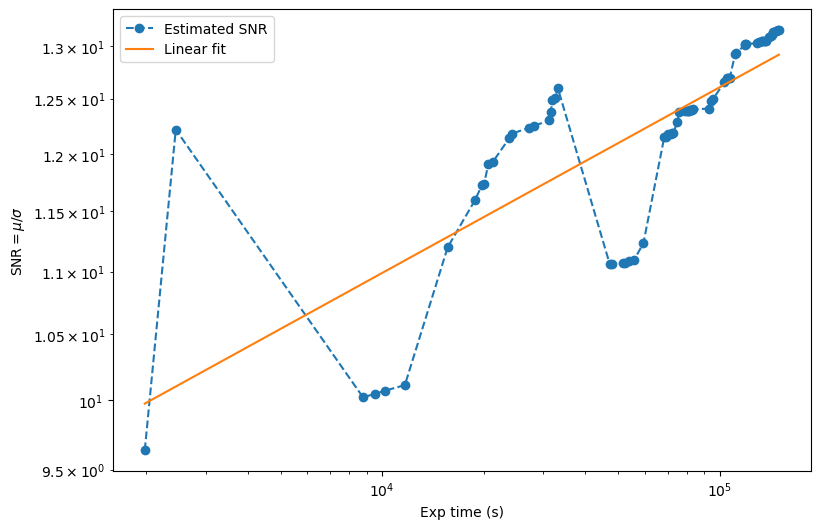

In [205]:
print('Estimated log-signal-to-noise ratio:')
print(SNR)
plt.figure(figsize=(9,6))
plt.plot(exptime,SNR,'--o',label='Estimated SNR')
plt.plot()
plt.ylabel('SNR$=\\mu/\\sigma$')
plt.xlabel('Exp time (s)')
plt.xscale('log')
plt.yscale('log')
#linear regression
p, lsq = linReg(np.log10(exptime),np.log10(SNR))
print(p)
plt.plot(exptime,10**p[1]*exptime**p[0],'-',label='Linear fit')
plt.legend()

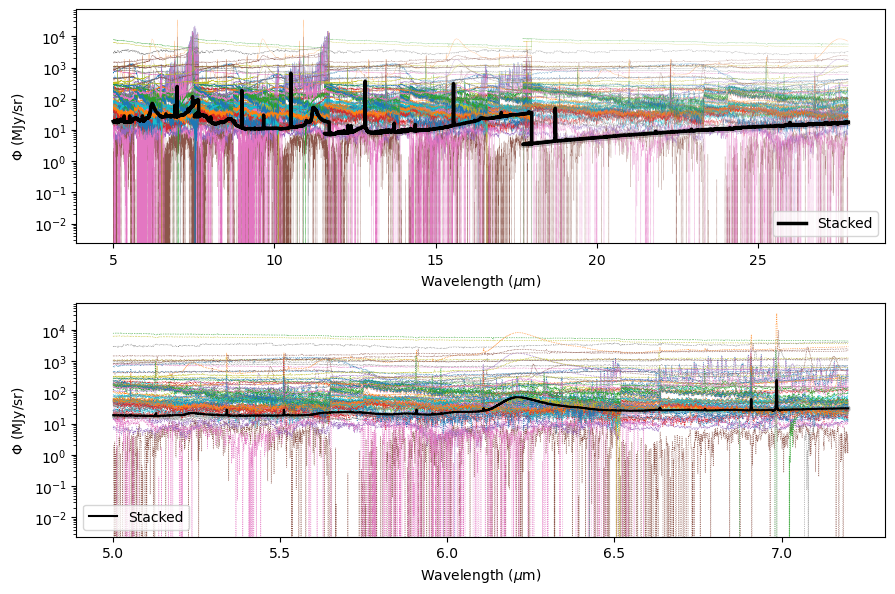

In [206]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5, M2=7.2, Ch1Arr=Ch1Arr, Ch2Arr=Ch2Arr, Ch3Arr=Ch3Arr, Ch4Arr=Ch4Arr) 

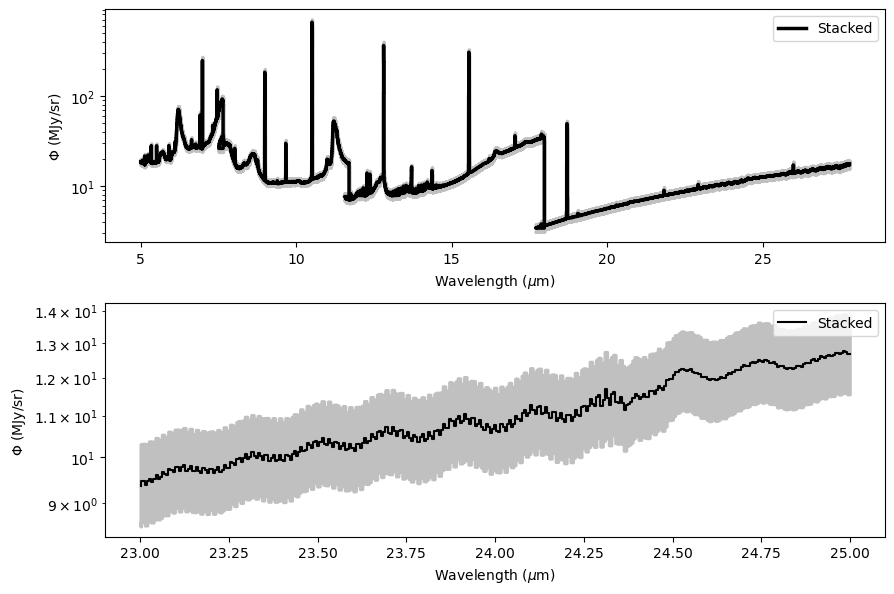

In [207]:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=23, M2=25)

In [208]:
#Output array files:
np.savez('stkData.npz', ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)
np.savez('metaData.npz', expt=exptArr, l=longArr, b=latArr)

# Testing

In [ ]:
import scipy.constants as constants
print(constant

* Really small SNR + wrong powerf
* undefined error in ch4